In [6]:
import numpy as np
import pickle as pkl

from matplotlib import pyplot as plt

from IPython.display import HTML
import matplotlib.animation

from sklearn.decomposition import PCA
from scipy.optimize import minimize

### Toolbox

In [7]:
def Plot(coords, bond=None, names=None, view=[30,60], radius=None):
    # %matplotlib ipympl
    ax = plt.figure().add_subplot(projection='3d')
    ax.view_init(*view)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])

    if not np.any(bond==None):
        for i in range(len(bond)):
            plt.plot(*[[coords[bond[i,0],j],coords[bond[i,1],j]] for j in range(3)], color=[0.3,0.3,0.3], linewidth=2, alpha=0.65)
            
    for i in range(len(coords)):
        if names==None:
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'ko', markersize = 8)
        elif names[i]=='C':
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'ko', markersize = 8)
        elif names[i]=='H':
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'wo', markersize = 8)
        elif names[i]=='O':
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'ro', markersize = 8)
        elif names[i]=='Er':
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'go', markersize = 8)
        else:
            plt.plot(coords[i,0],coords[i,1],coords[i,2], 'bo', markersize = 8)
    
    if radius!=None:
        N = len(coords)
        bond_full = np.zeros((N,N))
        for k in range(N):
            for l in bond[np.where(bond[:,0]==k),1][0]:
                bond_full[k,l] = 1
                bond_full[l,k] = 1
        for i in range(N):
            for j in range(N):
                if np.linalg.norm(coords[i,:]-coords[j,:])<radius:
                    if j in np.where(bond_full[i,:])[0]:
                        Color = [0.1,0.8,0.2]
                    else:
                        Color = [0.8,0.1,0.1]
                    plt.plot(*[[coords[i,k],coords[j,k]] for k in range(3)], color=Color, linewidth=2, alpha=0.65)


    ax.set_xlim3d(-2,2)
    ax.set_ylim3d(-2,2)
    ax.set_zlim3d(-2,2)
    plt.show()

In [8]:
def readCIF(filename):
    with open(filename) as f:
        lines = f.readlines()
    i = 0
    while lines[i]!="loop_\n":
        i+=1
    i+=1
    while lines[i]!="loop_\n":
        i+=1
        
    cell_data = lines[i-6:i]
    atoms_data = lines[i+9:]
    
    # Cell data extraction
    cell_params = np.zeros((6), float)
    for i in range(6):
        cell_params[i] = cell_data[i].split()[1]
    
    # Atoms data extraction
    N = len(atoms_data)
    names = [0]*N
    coords_frac = np.zeros((N,3))
    for i in range(N):
        split = atoms_data[i].split()
        names[i] = split[1]
        coords_frac[i,:] = split[2:5]
    
    return cell_params, names, coords_frac 


def readMOL(filename):
    with open(filename) as f:
        lines = f.readlines()
        
    i = 0
    while lines[i]!='M  V30 BEGIN ATOM\n':
        i+=1
    j = i+1
    while lines[j]!='M  V30 END ATOM\n':
        j+=1
    coords_data = lines[i+1:j]
    while lines[i]!='M  V30 BEGIN BOND\n':
        i+=1
    bond_data = lines[i+1:-3]
    
    N = len(coords_data)
    coords = np.zeros((N,3), float)
    names = [0]*N
    for i in range(N):
        coords[i,:] = coords_data[i].split()[4:7]
        names[i] = coords_data[i].split()[3]

    N = len(bond_data)
    bond = np.zeros((N,2), int)
    for i in range(N):
        bond[i,:] = bond_data[i].split()[4:6]
    bond = bond-1
    
    return names, coords, bond


def readMOL2(filename):
    with open(filename) as f:
        lines = f.readlines()
        
    i = 0
    while lines[i]!='@<TRIPOS>ATOM\n':
        i+=1
    j = i+1
    while lines[j]!='@<TRIPOS>BOND\n':
        j+=1
    coords_data = lines[i+1:j]
    while lines[i]!='@<TRIPOS>SUBSTRUCTURE\n':
        i+=1
    bond_data = lines[j+1:i]
    
    N = len(coords_data)
    coords = np.zeros((N,3), float)
    names = [0]*N
    for i in range(N):
        coords[i,:] = coords_data[i].split()[2:5]
        names[i] = coords_data[i].split()[1]
        if names[i][1].isnumeric():
            names[i] = names[i][0]
        else:
            names[i] = names[i][0:2]

    N = len(bond_data)
    bond = np.zeros((N,2), int)
    for i in range(N):
        bond[i,:] = bond_data[i].split()[1:3]
    bond = bond-1
    
    return names, coords, bond



def coordchange(cell, coords):
    a,b,c = cell[:3]#*0.529177
    alpha, beta, gamma = cell[3:]*np.pi/180
    A = np.array([[a,0,0],[b*np.sin(gamma-np.pi/2), b*np.cos(gamma-np.pi/2),0],[c*np.sin(alpha-np.pi/2), c*np.sin(beta-np.pi/2), c*np.sqrt(1-np.sin(alpha-np.pi/2)**2-np.sin(beta-np.pi/2)**2)]]).transpose()
    
    N = len(coords)
    coords_ = np.zeros((N,3))

    for i in range(N):
        coords_[i,:] = A@coords[i,:]
    return coords_


def cif2xyz(filenamecif, filenamexyz):
    
    cell_params, names, coords_frac = readCIF(filenamecif)
    coords_ = coordchange(cell_params, coords_frac)
    
    N = len(coords_)
    XYZ_str = str(N)+'\n'+'\n'
    for i in range(N):
        XYZ_str += names[i]+' '+str(coords_[i][0])+' '+str(coords_[i][1])+' '+str(coords_[i][2])+'\n'

        f = open(filenamexyz, "w")
    f.write(XYZ_str)
    f.close()




def plane(coords):
    pca = PCA(n_components=2)
    pca.fit(coords)
    return np.cross(pca.components_[0],pca.components_[1])


def remove(arr, names, coords, bond):

    for i in np.flip(np.sort(np.array(arr))):
        names.pop(i)
        coords = np.delete(coords,i,0)
        bond = np.delete(bond,np.where(bond==i)[0],0)
        bond[np.where(bond>=i)] -= 1

    return names, coords, bond

# [remove atoms from main mol] + [remove noise mol]
META_DATA = {'AHOKIR01': {'Remove': []+[24,34,37], 'HyperParams': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':50, 'D': 100}, 'Distance': 0.315}, 
             'MOCJEU': {'Remove': [33,32,31,10,9,8,27,22,21]+[35,36,37], 'HyperParams': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.35},
             'BOHGOU': {'Remove': [18]+[21,22], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.31},
             'CICYIX': {'Remove': [27]+[28,29,30], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':20, 'D': 100}, 'Distance': 0.29},
             'EBEMEF': {'Remove': []+[16,17,18,19,20,21], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':20, 'D': 100}, 'Distance': 0.29},
             'FIGXAU': {'Remove': [14,15,16]+[], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.29},
             'FIGXEY': {'Remove': [14,15,16]+[], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.33},
             'FIVNAZ': {'Remove': [4,6,7,11,15,16,9]+[19,20,21], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.4},
             # NaN 'FUTJOV': {'Remove': [10,11,12]+[30,31,32,33,34,35], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.4},
             'GISZUD': {'Remove': []+[0,1,2,3,4], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.35},
             'HAKWUM': {'Remove': [27,13,14,15]+[0,1,2], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':50, 'D': 100}, 'Distance': 0.31},
             'KAHPUE': {'Remove': [15]+[34,0,1,2,3,4,5], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.31}, # Missing H
             'KECRAL10': {'Remove': [12,46]+[48,49,50,51,52,53,54,55,56,57,58,59,60,61], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':50, 'D': 100}, 'Distance': 0.33},
             'LUFQUZ01': {'Remove': [14]+[28,29,30,31], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.33},
             'NINHOH': {'Remove': [4]+[24,25,26,27,28,29,18,19,20,21,22,23], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':60, 'D': 100}, 'Distance': 0.33}, # Missing H
             'OLOKEF': {'Remove': [30,31,32,40,41,42]+[43,44], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':60, 'D': 100}, 'Distance': 0.3},
             'PIYZAZ': {'Remove': []+[9], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':100, 'D': 100}, 'Distance': 0.3},
             # Irremovable hexagon 'REGJIW': {'Remove': []+[44,45], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':30, 'D': 100}, 'Distance': 0.3},
             'RENWEM01': {'Remove': [6,11,12]+[21,22,23], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':100, 'D': 100}, 'Distance': 0.28},
             'RONZID': {'Remove': []+[8,9,12,11,7,10], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-1, 'H2':10, 'D': 100}, 'Distance': 0.28},
             'RURPAW': {'Remove': [21]+[0,1,2,3,4,5,6], 'HyperParam': {'C1': 0.75, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.28},
             'RURPEA': {'Remove': [12]+[28,29,30,31,32,33,34,35,36,37], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.31},
             'SOBZOY': {'Remove': [12]+[28,29,30,31,32], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.29},
             'TILVUF': {'Remove': []+[7,8,9,10,11,12,13], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.29},
             'TILWAM': {'Remove': []+[0,1,2,3], 'HyperParam': {'C1': 0.5, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':50, 'D': 100}, 'Distance': 0.28},
             'UHISOU': {'Remove': [37,38,39,40,41,42]+[43,44,45,46,47,48], 'HyperParam': {'C1': 0.75, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.33} }
             # Irremovable hexagon 'XOMCIL': {'Remove': [25,26,27,28,9,18,19]+[], 'HyperParam': {'C1': 0.75, 'K': 1, 'H1': 5, 'C2': 1e-2, 'H2':10, 'D': 100}, 'Distance': 0.33},

In [9]:
def V(coords_flat, C=1e-2, K=1, H=5):
    N = len(coords_flat)//3
    x = coords_flat.reshape((N,3))
    V = 0
    for i in range(N):
        for j in np.concatenate((np.arange(i),np.arange(i+1,N))):
            if not j in bond[np.where(bond[:,0]==i),1][0]:
                V += C/(np.linalg.norm(x[i,:]-x[j,:]))
    
        for j in bond[np.where(bond[:,0]==i),1][0]:
            V += K*1/2*(np.linalg.norm(x[i,:]-x[j,:]) - 1.2)**2
        
        V += H*1/2*(np.dot(n,x[i,:]))**2
    return V

def F(coords_flat, C=1e-2, K=1, H=5):
    N = len(coords_flat)//3
    x = coords_flat.reshape((N,3))
    F = np.zeros((N,3))
    for i in range(N):
        for j in np.concatenate((np.arange(i),np.arange(i+1,N))):
            if not j in bond[np.where(bond[:,0]==i),1][0]:
                F[i,:] = C/(np.linalg.norm(x[i,:]-x[j,:]))**2*(x[j,:]-x[i,:])/np.linalg.norm(x[i,:]-x[j,:])
    
        for j in bond[np.where(bond[:,0]==i),1][0]:
            F[i,:] += -K*(np.linalg.norm(x[i,:]-x[j,:]) - 1.2) * (x[i,:]-x[j,:])/np.linalg.norm(x[i,:]-x[j,:])

        F[i,:] += -H*(np.dot(n,x[i,:]))*n

    return -F.reshape(-1)

def V2(coords_flat, C=1e-2, H=5, D=5):
    x = coords_flat.reshape((N,3))
    V = 0
    for i in range(N):
        for j in range(N):
            if j!=i:
                V += C/np.linalg.norm(x[i,:]-x[j,:])
                if j in np.where(bond_full[i,:])[0]:#bond[np.where(bond[:,0]==i),1][0]:
                    V += 1/2*D*int(np.linalg.norm(x[i,:]-x[j,:]) > d*0.9)*(np.linalg.norm(x[i,:]-x[j,:])-d*0.9)**2 #D*max(0, np.linalg.norm(x[i,:]-x[j,:]) - d)
                else:
                    V += 1/2*D*int(np.linalg.norm(x[i,:]-x[j,:]) < d*1.1)*(np.linalg.norm(x[i,:]-x[j,:])-d*1.1)**2 #D*max(0, d - np.linalg.norm(x[i,:]-x[j,:]))
    
        V += H*1/2*(np.dot(n,x[i,:]))**2
    return V

def F2(coords_flat, C=1e-2, H=5, D=5):
    x = coords_flat.reshape((N,3))
    F = np.zeros((N,3))
    for i in range(N):
        for j in range(N):
            if j!=i:
                F[i,:] += -C/np.linalg.norm(x[i,:]-x[j,:])**3*(x[j,:]-x[i,:])
                if j in np.where(bond_full[i,:])[0]:#bond[np.where(bond[:,0]==i),1][0]:
                    F[i,:] += D*int(np.linalg.norm(x[i,:]-x[j,:]) > d*0.9) * (x[j,:]-x[i,:])/np.linalg.norm(x[i,:]-x[j,:])*(np.linalg.norm(x[i,:]-x[j,:])-d*0.9)
                else:
                    F[i,:] += -D*int(np.linalg.norm(x[i,:]-x[j,:]) < d*1.1) * (x[j,:]-x[i,:])/np.linalg.norm(x[i,:]-x[j,:])*(d*1.1-np.linalg.norm(x[i,:]-x[j,:]))
        F[i,:] += -H*(np.dot(n,x[i,:]))*n
    return -F.reshape(-1)



### Loading of the molecule, removing the noise in the data, and plot

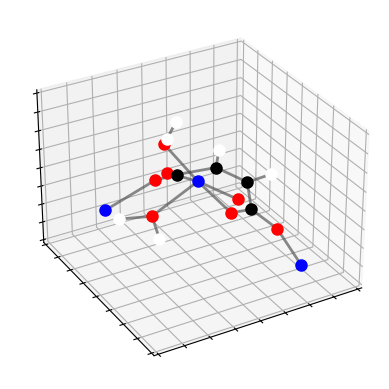

In [10]:
mol_str = 'BOHGOU'
names, coords, bond = readMOL2('dataset_mol2/'+mol_str+'.mol2')

list_rmv = META_DATA[mol_str]['Remove']
names, coords, bond = remove(list_rmv, names, coords, bond)


N = len(coords)
bond_full = np.zeros((N,N))
for i in range(N):
    for j in bond[np.where(bond[:,0]==i),1][0]:
        bond_full[i,j] = 1
        bond_full[j,i] = 1

Plot((coords - np.mean(coords,axis=0))/2, bond, names)

### Projection
$$  V = \frac{1}{2}H(\mathbf{n}\cdot \mathbf{x})^2 + \frac{1}{2}K\sum_{\langle i,j\rangle} \left(|\mathbf{x}_i - \mathbf{x}_j| - d_{i,j}\right)^2 + \sum_{(i,j)} \frac{C}{|\mathbf{x}_i - \mathbf{x}_j|} $$

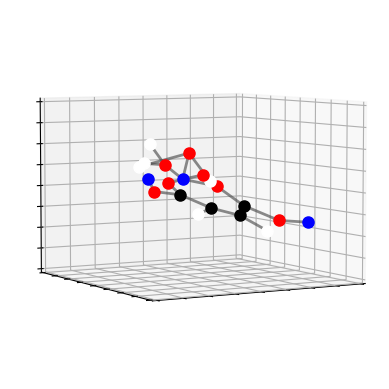

In [11]:
C = 0.5
K = 1
H = 5

n = plane(coords)
res = minimize(lambda x: V(x,C=C,K=K,H=H), x0 = coords.reshape((3*N)), jac=lambda x:F(x,C=C,K=K,H=H), method='BFGS')
coords_ = res.x.reshape((-1,3))/2
Plot(coords_-np.mean(coords_, axis=0), bond, names, view=[5,60])

### Projection
$$V = \frac{1}{2}H(\mathbf{n}\cdot \mathbf{x})^2 + \frac{1}{2}D\sum_{\langle i,j\rangle, |\mathbf{x}_i - \mathbf{x}_j|>d} \left(|\mathbf{x}_i - \mathbf{x}_j| - d\right)^2 + \frac{1}{2}D\sum_{(i,j), |\mathbf{x}_i - \mathbf{x}_j|<d} \left(|\mathbf{x}_i - \mathbf{x}_j| - d\right)^2 + \sum_{(i,j)} \frac{C}{|\mathbf{x}_i - \mathbf{x}_j|}$$

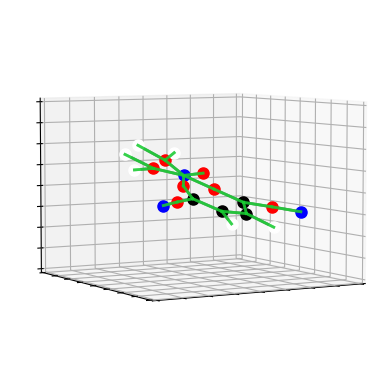

In [12]:
C = 1e-2
H = 10
D = 100
d = np.mean([np.linalg.norm(np.array([coords_[bond[i,0],j]-coords_[bond[i,1],j] for j in range(3)])) for i in range(len(bond)) ])
res = minimize(lambda x: V2(x,C=C,H=H,D=D), x0 = coords_.reshape((3*N)), method='BFGS', jac=lambda x: F2(x,C=C,H=H,D=D))
coords__ = res.x.reshape((-1,3))
Plot(coords__-np.mean(coords__, axis=0), bond, names, view=[5,60], radius=d*1.01)

### Coordinate in the plane

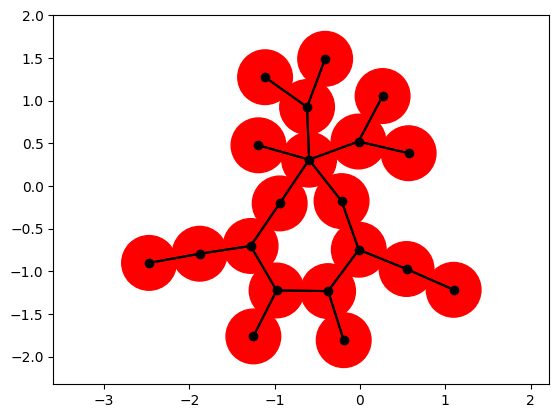

In [13]:
a = np.array([n[1], -n[0], 0])/np.sqrt(1-n[2]**2)
b = np.array([n[0]*n[2], n[1]*n[2], n[2]**2-1])/np.sqrt(1-n[2]**2)

plane_coords = np.zeros((N,2))
for i in range(N):
    plane_coords[i,:] = np.array([-np.dot(a,coords__[i,:]),-np.dot(b,coords__[i,:])])

fig, ax = plt.subplots()
ax.plot(plane_coords[:,0], plane_coords[:,1],'ko')
for i in range(N):
    ax.add_patch(plt.Circle(plane_coords[i,:], 0.32, color='r'))
    for j in np.where(bond_full[i,:])[0]:
        plt.plot(np.array([plane_coords[i,0],plane_coords[j,0]]), np.array([plane_coords[i,1],plane_coords[j,1]]), 'k-')
plt.axis('equal')
plt.show()

l = []
for i in range(N):
    for j in np.where(bond_full[i,:])[0]:
        l.append(np.linalg.norm(plane_coords[i,:] - plane_coords[j,:]))

In [14]:
print(l)

[0.6170953255495838, 0.6174082167893031, 0.6169439595649874, 0.6174208575869503, 0.6166408776922978, 0.6036909628927819, 0.6032145887769448, 0.6170953255495838, 0.6042319407995855, 0.6174082167893031, 0.6040522456637609, 0.6036603158741602, 0.6031950023201242, 0.6169439595649874, 0.603505371897015, 0.6034583053718362, 0.6174208575869503, 0.6035003006677333, 0.6034941484664893, 0.6036909628927819, 0.6042319407995855, 0.6038678636821483, 0.6038678636821483, 0.6036874332198756, 0.6033195460445796, 0.6036874332198756, 0.6037483596885735, 0.6033137059812027, 0.6040522456637609, 0.6036603158741602, 0.6037483596885735, 0.6033195460445796, 0.6033137059812027, 0.603505371897015, 0.6034583053718362, 0.6035003006677333, 0.6034941484664893, 0.6166408776922978, 0.6031950023201242, 0.6032145887769448]
